# MODEL 5_LSS_all21
### Contains all fixed-before-conditional trials, regardless of interfering BL
### Combines A & C trials into single regressor
### Analysis isolated to only 20 trials surrounding largest deviation (point of greatest learning)

#  WMAZE Beta Series Correlation Analysis

## Obtains correlation values for the regions of interest:
### Hippocampus (FS labels: hippocampus [17, 53])
### Dorsal caudate (hand-drawn by Mandy)
### Medial PFC (FS labels: rostral anterior cingulate [1026,1014] & medial orbitofrontal [2026,2155])
### Dorsolateral PFC (Lausanne atlas: dlPFC)

### Use Glob to grab all previously created anatomy masks and beta series cope files

In [4]:
from glob import glob

sids = ['WMAZE_001', 'WMAZE_002', 'WMAZE_004', 'WMAZE_005', 'WMAZE_006', 
        'WMAZE_007', 'WMAZE_008', 'WMAZE_009', 'WMAZE_010', 'WMAZE_012',
        'WMAZE_017', 'WMAZE_018', 'WMAZE_019', 'WMAZE_020', 'WMAZE_021',  
        'WMAZE_022', 'WMAZE_023', 'WMAZE_024', 'WMAZE_026', 'WMAZE_027']

proj_dir = '/home/data/madlab/data/mri/wmaze'
 
mask_filenames = []
cope_files = []

for SID in sids:
    # Grab the mask files for each subject
    mask_filenames_glob = glob(proj_dir + '/roi_analysis/mask/anat_masks/_subject_id_' + SID + '/_anatmask_xfm*/*')
    mask_filenames.append(sorted(mask_filenames_glob))
    # Grab the cope files for each subject
    subjcopes_glob = glob(proj_dir + '/frstlvl/wmaze_MRthesis/fixed_before_conditional/model5_LSS_all21/merge_copes/'
                          + SID + '/merged/cope_*')
    cope_files.append(sorted(subjcopes_glob))
    # If there are no cope files, print subject id
    if len(cope_files[-1]) == 0:
        print(SID)

### Cell to double-check the array indexing for both the masks and the copes

In [5]:
print '0. left dlPFC'
print(mask_filenames[0][0]) #lh-dlPFC Lausanne
print""
print '1. left hippocampus'
print(mask_filenames[0][1]) #lh-hippocampus
print""
print '2. left mPFC (rac-only)'
print(mask_filenames[0][2]) #lh-mPFC_rac-only
print""
print '3. left mPFC (orig)'
print(mask_filenames[0][3]) #lh-mPFC (orig)
print""
print '4. left putamen'
print(mask_filenames[0][4]) #lh-putamen
print""
print '5. left caudate'
print(mask_filenames[0][5]) #lh-caudate
print""
print '6. right dlPFC'
print(mask_filenames[0][6]) #rh-dlPFC Lausanne
print""
print '7. right hippocampus'
print(mask_filenames[0][7]) #rh-hippocampus
print""
print '8. right mPFC (orig)'
print(mask_filenames[0][8]) #rh-mPFC (orig)
print""
print '9. right putamen'
print(mask_filenames[0][9]) #rh-putamen
print""
print '10. right caudate'
print(mask_filenames[0][10]) #rh-caudate
print""
print '11. right mPFC (rac-only)'
print(mask_filenames[0][11]) #rh-mPFC_rac_only
print""
print '12. left mPFC (rac-cac)'
print(mask_filenames[0][12]) #lh-mPFC_rac-cac
print""
print '13. right mPFC (rac-cac)'
print(mask_filenames[0][13]) #rh-mPFC_rac-cac
print""

print '-----'

print 'cope_corr'
print(cope_files[0][0]) #cope_corr
print ""
print 'cope_incorr'
print(cope_files[0][1]) #cope_incorr

#for i in cope_files:
#    print(len(i))


0. left dlPFC
/home/data/madlab/data/mri/wmaze/roi_analysis/mask/anat_masks/_subject_id_WMAZE_001/_anatmask_xfm0/lh-dlPFC_lausanne_warped.nii.gz

1. left hippocampus
/home/data/madlab/data/mri/wmaze/roi_analysis/mask/anat_masks/_subject_id_WMAZE_001/_anatmask_xfm0/lh-hippocampus_warped.nii.gz

2. left mPFC (rac-only)
/home/data/madlab/data/mri/wmaze/roi_analysis/mask/anat_masks/_subject_id_WMAZE_001/_anatmask_xfm0/lh-mPFC_rac-only_warped.nii.gz

3. left mPFC (orig)
/home/data/madlab/data/mri/wmaze/roi_analysis/mask/anat_masks/_subject_id_WMAZE_001/_anatmask_xfm0/lh-mPFC_warped.nii.gz

4. left putamen
/home/data/madlab/data/mri/wmaze/roi_analysis/mask/anat_masks/_subject_id_WMAZE_001/_anatmask_xfm0/lh-putamen_warped.nii.gz

5. left caudate
/home/data/madlab/data/mri/wmaze/roi_analysis/mask/anat_masks/_subject_id_WMAZE_001/_anatmask_xfm0/lh_caudate_anat_mask_warped.nii.gz

6. right dlPFC
/home/data/madlab/data/mri/wmaze/roi_analysis/mask/anat_masks/_subject_id_WMAZE_001/_anatmask_xfm0/rh

### Use binarized mask to obtain activation in left & right hemisphere for each ROI

In [11]:
import nibabel as nb
import pandas as pd
import numpy as np
from scipy import stats


#Dictionary containing multiple arrays referenced by keywords
all_data = {'subjid':[],
            'lh_hp_corr':[], 'rh_hp_corr':[], 
            'lh_hp_incorr':[], 'rh_hp_incorr':[],                 
            'lh_caudate_corr':[], 'rh_caudate_corr':[], 
            'lh_caudate_incorr':[], 'rh_caudate_incorr':[],  
            'lh_dlPFC_corr':[], 'rh_dlPFC_corr':[], 
            'lh_dlPFC_incorr':[], 'rh_dlPFC_incorr':[],            
            'lh_mPFC_corr':[], 'rh_mPFC_corr':[], 
            'lh_mPFC_incorr':[], 'rh_mPFC_incorr':[]}

corr_matrix = np.zeros((len(sids), 5))

# For each interation in the length of subject ids
for i in range(len(sids)):
    #Append the subject id
    all_data['subjid'].append(sids[i])
    #Load the left and right hippocampus mask files using Nibabel 
    lh_hp_img = nb.load(mask_filenames[i][1])
    rh_hp_img = nb.load(mask_filenames[i][7])
    
    lh_caudate_img = nb.load(mask_filenames[i][5])
    rh_caudate_img = nb.load(mask_filenames[i][10])
    
    lh_dlPFC_img = nb.load(mask_filenames[i][0])
    rh_dlPFC_img = nb.load(mask_filenames[i][6])
    
    lh_mPFC_img = nb.load(mask_filenames[i][12])
    rh_mPFC_img = nb.load(mask_filenames[i][13])
    
    #Load copes for corr vs incorr betas
    cope_corr_img = nb.load(cope_files[i][0])
    cope_incorr_img = nb.load(cope_files[i][1])
     
  
    ########################
    ### Left Hippocampus ###
    ########################
    
    # cope_corr
    lh_hp_corr_data = cope_corr_img.get_data()[lh_hp_img.get_data() > 0.]
    all_data['lh_hp_corr'].append(lh_hp_corr_data[0:-1])
    
    # cope_incorr
    lh_hp_incorr_data = cope_incorr_img.get_data()[lh_hp_img.get_data() > 0.]
    all_data['lh_hp_incorr'].append(lh_hp_incorr_data[0:-1])
    
    #########################
    ### Right Hippocampus ###
    #########################
    
    # cope_corr
    rh_hp_corr_data = cope_corr_img.get_data()[rh_hp_img.get_data() > 0.]
    all_data['rh_hp_corr'].append(rh_hp_corr_data[0:-1])

    # cope_incorr
    rh_hp_incorr_data = cope_incorr_img.get_data()[rh_hp_img.get_data() > 0.]
    all_data['rh_hp_incorr'].append(rh_hp_incorr_data[0:-1])
    
    #####################
    ### Left Caudate ###
    ##################### 
    
    # cope_corr
    lh_caudate_corr_data = cope_corr_img.get_data()[lh_caudate_img.get_data() > 0.]
    all_data['lh_caudate_corr'].append(lh_caudate_corr_data[0:-1])

    # cope_incorr
    lh_caudate_incorr_data = cope_incorr_img.get_data()[lh_caudate_img.get_data() > 0.]
    all_data['lh_caudate_incorr'].append(lh_caudate_incorr_data[0:-1])
    
    #####################
    ### Right Caudate ###
    ##################### 
    
    # cope_corr
    rh_caudate_corr_data = cope_corr_img.get_data()[rh_caudate_img.get_data() > 0.]
    all_data['rh_caudate_corr'].append(rh_caudate_corr_data[0:-1])

    # cope_incorr
    rh_caudate_incorr_data = cope_incorr_img.get_data()[rh_caudate_img.get_data() > 0.]
    all_data['rh_caudate_incorr'].append(rh_caudate_incorr_data[0:-1])  
    
    ####################
    #### Left mPFC #####
    ####################
    
    # cope_corr
    lh_mPFC_corr_data = cope_corr_img.get_data()[lh_mPFC_img.get_data() > 0.]
    all_data['lh_mPFC_corr'].append(lh_mPFC_corr_data[0:-1])
    
    # cope_incorr
    lh_mPFC_incorr_data = cope_incorr_img.get_data()[lh_mPFC_img.get_data() > 0.]
    all_data['lh_mPFC_incorr'].append(lh_mPFC_incorr_data[0:-1])    
    
    #####################
    #### Right mPFC #####
    #####################
    
    # cope_corr
    rh_mPFC_corr_data = cope_corr_img.get_data()[rh_mPFC_img.get_data() > 0.]
    all_data['rh_mPFC_corr'].append(rh_mPFC_corr_data[0:-1])

    # cope_incorr
    rh_mPFC_incorr_data = cope_incorr_img.get_data()[rh_mPFC_img.get_data() > 0.]
    all_data['rh_mPFC_incorr'].append(rh_mPFC_incorr_data[0:-1]) 
    
    ####################
    #### Left dlPFC ####
    ####################
    
    # cope_corr
    lh_dlPFC_corr_data = cope_corr_img.get_data()[lh_dlPFC_img.get_data() > 0.]
    all_data['lh_dlPFC_corr'].append(lh_dlPFC_corr_data[0:-1])
    
    # cope_incorr
    lh_dlPFC_incorr_data = cope_incorr_img.get_data()[lh_dlPFC_img.get_data() > 0.]
    all_data['lh_dlPFC_incorr'].append(lh_dlPFC_incorr_data[0:-1])  
    
    #####################
    ### Right dlPFC ###
    #####################
    
    # cope_corr
    rh_dlPFC_corr_data = cope_corr_img.get_data()[rh_dlPFC_img.get_data() > 0.]
    all_data['rh_dlPFC_corr'].append(rh_dlPFC_corr_data[0:-1])

    # cope_incorr
    rh_dlPFC_incorr_data = cope_incorr_img.get_data()[rh_dlPFC_img.get_data() > 0.]
    all_data['rh_dlPFC_incorr'].append(rh_dlPFC_incorr_data[0:-1])
    
    
    all_keys = ['lh_hp_corr', 'rh_hp_corr', 
                'lh_hp_incorr', 'rh_hp_incorr',                 
                'lh_caudate_corr', 'rh_caudate_corr', 
                'lh_caudate_incorr', 'rh_caudate_incorr',  
                'lh_dlPFC_corr', 'rh_dlPFC_corr', 
                'lh_dlPFC_incorr', 'rh_dlPFC_incorr',            
                'lh_mPFC_corr', 'rh_mPFC_corr', 
                'lh_mPFC_incorr', 'rh_mPFC_incorr']
    
    for key in all_keys: 
        # averaging each column for only the current participant 
        all_data[key][-1] = np.mean(all_data[key][-1], axis = 0)
       
    #Combined Hippocampus average for corr and incorr for current sub
    all_data['hp_corr'] = (np.array(all_data['lh_hp_corr'][-1]) + np.array(all_data['rh_hp_corr'][-1]))/2.
    all_data['hp_incorr'] = (np.array(all_data['lh_hp_incorr'][-1]) + np.array(all_data['rh_hp_incorr'][-1]))/2.
                             
    #Combined Caudate average for corr and incorr for current sub
    all_data['caudate_corr'] = (np.array(all_data['lh_caudate_corr'][-1]) + np.array(all_data['rh_caudate_corr'][-1]))/2.
    all_data['caudate_incorr'] = (np.array(all_data['lh_caudate_incorr'][-1]) + np.array(all_data['rh_caudate_incorr'][-1]))/2.

    # Combined mPFC average for corr and incorr for current sub
    all_data['mPFC_corr'] = (np.array(all_data['lh_mPFC_corr'][-1]) + np.array(all_data['rh_mPFC_corr'][-1]))/2.
    all_data['mPFC_incorr'] = (np.array(all_data['lh_mPFC_incorr'][-1]) + np.array(all_data['rh_mPFC_incorr'][-1]))/2.

    #Combined dlPFC average for corr and incorr for current sub
    all_data['dlPFC_corr'] = (np.array(all_data['lh_dlPFC_corr'][-1]) + np.array(all_data['rh_dlPFC_corr'][-1]))/2.
    all_data['dlPFC_incorr'] = (np.array(all_data['lh_dlPFC_incorr'][-1]) + np.array(all_data['rh_dlPFC_incorr'][-1]))/2.   
   
    
    # Creation of the correlation matrix (with subject id column)
    corr_matrix[i][0] = float(sids[i][-3:])
    corr_matrix[i][1] = stats.pearsonr(all_data['hp_corr'], all_data['mPFC_corr'])[0]
    corr_matrix[i][2] = stats.pearsonr(all_data['hp_incorr'], all_data['mPFC_incorr'])[0]
    corr_matrix[i][3] = stats.pearsonr(all_data['caudate_corr'], all_data['dlPFC_corr'])[0]
    corr_matrix[i][4] = stats.pearsonr(all_data['caudate_incorr'], all_data['dlPFC_incorr'])[0]

##  Non-normalized correlation matrix for beta series

In [12]:
import pandas as pd
corr_chart = {}
corr_chart['HPC-mPFC_corr'] = corr_matrix[:, 1] #hpc-mpfc corr
corr_chart['HPC-mPFC_incorr'] = corr_matrix[:, 2] #hpc-mpfc incorr
corr_chart['Caudate-dlPFC_corr'] = corr_matrix[:, 3] #caudate-dlpfc corr
corr_chart['Caudate-dlPFC_incorr'] = corr_matrix[:, 4] #caudate-dlpfc incorr
corr_chart_df = pd.DataFrame.from_dict(corr_chart)

In [13]:
corr_chart_df

,Caudate-dlPFC_corr,Caudate-dlPFC_incorr,HPC-mPFC_corr,HPC-mPFC_incorr
0,0.581055,0.642282,0.630706,0.600564
1,0.797703,-0.203779,0.741348,0.699202
2,0.308959,0.585249,0.674546,0.856116
3,0.698636,0.481525,0.778971,0.809298
4,0.285225,0.511025,0.799554,0.869286
5,0.560334,0.832812,0.593553,0.786110
6,0.711420,0.823197,0.750975,0.773803
7,0.252718,0.224982,0.374142,0.490312
8,0.385632,0.408423,0.381358,0.669755
9,0.388298,0.437637,0.268043,0.069007


0.605832630396
0.51611998445
0.552732798457
0.457207888365


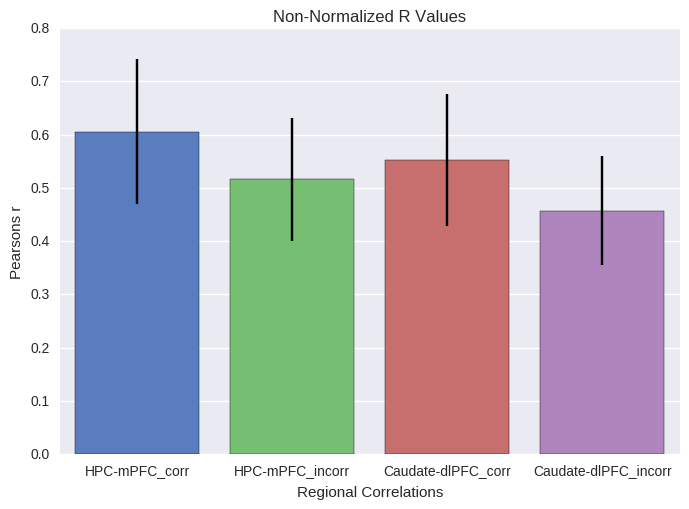

In [14]:
import seaborn as sns
#sns.set_style("ticks")
sns.set_palette('muted')
import matplotlib.pyplot as plt

N = 4
conditions = ['HPC-mPFC_corr', 'HPC-mPFC_incorr', 'Caudate-dlPFC_corr', 'Caudate-dlPFC_incorr']
means_allsubjs = [np.average(corr_chart['HPC-mPFC_corr']), 
                  np.average(corr_chart['HPC-mPFC_incorr']),
                  np.average(corr_chart['Caudate-dlPFC_corr']), 
                  np.average(corr_chart['Caudate-dlPFC_incorr'])]
sem_allsubjs = [np.average(corr_chart['HPC-mPFC_corr']/(np.sqrt(len(sids)))), 
                np.average(corr_chart['HPC-mPFC_incorr']/(np.sqrt(len(sids)))),
                np.average(corr_chart['Caudate-dlPFC_corr']/(np.sqrt(len(sids)))), 
                np.average(corr_chart['Caudate-dlPFC_incorr']/(np.sqrt(len(sids))))]
print np.average(corr_chart['HPC-mPFC_corr'])
print np.average(corr_chart['HPC-mPFC_incorr'])
print np.average(corr_chart['Caudate-dlPFC_corr'])
print np.average(corr_chart['Caudate-dlPFC_incorr'])


ind = np.arange(N)
width = 0.5

fig, ax = plt.subplots()

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax = sns.barplot(ind, means_allsubjs, yerr = sem_allsubjs, ecolor = 'black')

ax.set_xticks(ind)
ax.set_xticklabels(conditions)
#ax.set_ylim(0,1)
ax.set_ylabel("Pearsons r")
ax.set_xlabel("Regional Correlations")
ax.set_title("Non-Normalized R Values")
plt.show()

## Normalized correlation matrix for beta series

In [30]:
# Use Numpy's arctangent function to normalize correlations
norm_corr = np.arctanh(corr_matrix[:, 1:])
#print(norm_corr)

In [31]:
import pandas as pd
norm_chart = {}
norm_chart['HPC-mPFC_corr'] = norm_corr[:, 0] #hpc-mpfc corr
norm_chart['HPC-mPFC_incorr'] = norm_corr[:, 1] #hpc-mpfc incorr
norm_chart['Caudate-dlPFC_corr'] = norm_corr[:, 2] #caudate-dlpfc corr
norm_chart['Caudate-dlPFC_incorr'] = norm_corr[:, 3] #caudate-dlpfc incorr
norm_chart_df = pd.DataFrame.from_dict(norm_chart)

In [32]:
norm_chart_df

,Caudate-dlPFC_corr,Caudate-dlPFC_incorr,HPC-mPFC_corr,HPC-mPFC_incorr
0,0.664053,0.762048,0.742587,0.694028
1,1.092264,-0.206672,0.953465,0.865737
2,0.319394,0.670410,0.819039,1.278617
3,0.864631,0.524968,1.042748,1.124992
4,0.293361,0.564117,1.097375,1.330151
5,0.633319,1.197245,0.683134,1.061167
6,0.890053,1.166654,0.975187,1.029739
7,0.258315,0.228898,0.393230,0.536471
8,0.406659,0.433717,0.401648,0.810298
9,0.409794,0.469304,0.274754,0.069117


### Descriptive Statistics

In [33]:
print "Mean: HPC-mPFC_corr"
print np.average(norm_corr[:, 0])
print "SD: HPC-mPFC_corr"
print np.std(norm_corr[:, 0])
print ""
print "Mean: HPC-mPFC_incorr"
print np.average(norm_corr[:, 1])
print "SD: HPC-mPFC_incorr"
print np.std(norm_corr[:, 1])
print ""
print "Mean: Caudate-dlPFC_corr"
print np.average(norm_corr[:, 2])
print "SD: Caudate-dlPFC_corr"
print np.std(norm_corr[:, 2])
print ""
print "Mean: Caudate-dlPFC_incorr"
print np.average(norm_corr[:, 3])
print "SD: Caudate-dlPFC_incorr"
print np.std(norm_corr[:, 3])

Mean: HPC-mPFC_corr
0.742963900627
SD: HPC-mPFC_corr
0.261585007578

Mean: HPC-mPFC_incorr
0.712583955561
SD: HPC-mPFC_incorr
0.546477962884

Mean: Caudate-dlPFC_corr
0.670702357332
SD: Caudate-dlPFC_corr
0.298686185608

Mean: Caudate-dlPFC_incorr
0.600636825404
SD: Caudate-dlPFC_incorr
0.509267024637


### Assumptions Tests 

In [56]:
print "Levene's Test of Equal Variance"
a = stats.levene(all_data['hp_corr'], all_data['mPFC_corr'])
print a

b = stats.shapiro(all_data['hp_corr'])
print ""
print "Shapiro-Wilk Test of Normality"
print "HPC", b

c = stats.shapiro(all_data['mPFC_corr'])
print "mPFC", c
print ""

print "D'Agostino and Pearson Test of Normality"
d = stats.mstats.normaltest(all_data['hp_corr'])
print d

Levene's Test of Equal Variance
LeveneResult(statistic=12.243221359784762, pvalue=0.00078425776425497388)

Shapiro-Wilk Test of Normality
HPC (0.966688871383667, 0.2955549955368042)
mPFC (0.9465897083282471, 0.06310275942087173)

D'Agostino and Pearson Test of Normality
NormaltestResult(statistic=1.9099489838666086, pvalue=0.38482196049201955)


### Inferential Statistics

In [58]:
print "Levene's Test of Equal Variance"
a = stats.levene(norm_corr[:, 0], norm_corr[:, 1])
b = stats.levene(norm_corr[:, 2], norm_corr[:, 3])
print a
print b
print ""
print 'HPC-mPFC_corr vs. HPC-mPFC_incorr'
print stats.wilcoxon(norm_corr[:, 0], norm_corr[:, 1])
print ""
print 'Caudate-dlPFC_corr vs. Caudate-dlPFC_incorr'
print stats.wilcoxon(norm_corr[:, 2], norm_corr[:, 3])
print ""
print "Bonferroni correction"
print '0.05/2 = 0.025'

Levene's Test of Equal Variance
LeveneResult(statistic=10.469409195108422, pvalue=0.0025161992268138223)
LeveneResult(statistic=2.6615841477886484, pvalue=0.11105970868084425)

HPC-mPFC_corr vs. HPC-mPFC_incorr
WilcoxonResult(statistic=101.0, pvalue=0.88129270865395981)

Caudate-dlPFC_corr vs. Caudate-dlPFC_incorr
WilcoxonResult(statistic=105.0, pvalue=1.0)

Bonferroni correction
0.05/2 = 0.025


In [52]:
print 'HPC-mPFC_corr vs. HPC-mPFC_incorr'
print stats.ttest_rel(norm_corr[:, 0], norm_corr[:, 1])
print ""

print 'Caudate-dlPFC_corr vs. Caudate-dlPFC_incorr'
print stats.ttest_rel(norm_corr[:, 2], norm_corr[:, 3])
print ""

print "Bonferroni correction"
print '0.05/2 = 0.025'

HPC-mPFC_corr vs. HPC-mPFC_incorr
Ttest_relResult(statistic=0.31741392062288043, pvalue=0.75439125807472807)

Caudate-dlPFC_corr vs. Caudate-dlPFC_incorr
Ttest_relResult(statistic=0.62911029730912893, pvalue=0.53676820764272049)

Bonferroni correction
0.05/2 = 0.025


In [9]:
stats.ttest_rel(corr_chart_df['HPC-mPFC_corr'], corr_chart_df['HPC-mPFC_incorr'])

Ttest_relResult(statistic=1.3816665267646466, pvalue=0.18310604600436886)

## Scatterplots illustrating regional activation across trials: Single subject

### Hippocampus vs. mPFC: Fixed before CORRECT

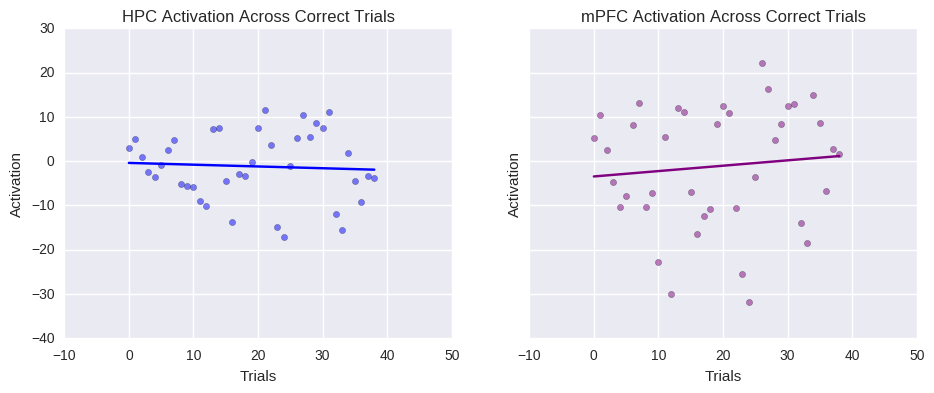

In [13]:
%matplotlib inline
# Scatterplot

ax = []
for a in range(0,39,1):
    ax.append(a)

x = ax

#print len(x)
y = all_data['hp_corr']
z = all_data['mPFC_corr']
#print len(y)
#print len(z)


fig, (ax, ax2) = plt.subplots(ncols = 2, figsize=(11, 4), sharex = True, sharey = True)
fit = np.polyfit(x, y, deg = 1)
ax.plot(x, np.array(fit[0]) * np.array(x) + np.array(fit[1]), color = 'blue')
ax.scatter(x, y, c = 'blue', alpha = 0.5)
ax.set_ylabel('Activation')
ax.set_xlabel('Trials')
ax.set_title('HPC Activation Across Correct Trials')


fit2 = np.polyfit(x, z, deg = 1)
ax2.plot(x, np.array(fit2[0]) * np.array(x) + np.array(fit2[1]), color = 'purple')
ax2.scatter(x, z, c = 'purple', alpha = 0.5)
ax2.set_ylabel('Activation')
ax2.set_xlabel('Trials')
ax2.set_title('mPFC Activation Across Correct Trials')

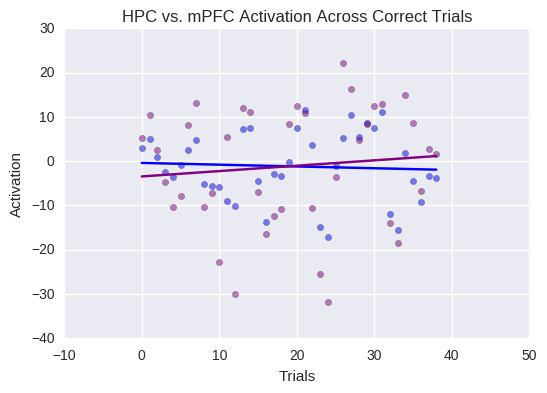

In [15]:
%matplotlib inline
# Scatterplot

ax = []
for a in range(0,39,1):
    ax.append(a)

x = ax

#print len(x)
y = all_data['hp_corr']
z = all_data['mPFC_corr']
#print len(y)
#print len(z)

fit = np.polyfit(x, y, deg = 1)
plt.plot(x, np.array(fit[0]) * np.array(x) + np.array(fit[1]), color = 'blue')
plt.scatter(x, y, c = 'blue', alpha = 0.5)

fit2 = np.polyfit(x, z, deg = 1)
plt.plot(x, np.array(fit2[0]) * np.array(x) + np.array(fit2[1]), color = 'purple')
plt.scatter(x, z, c = 'purple', alpha = 0.5)

plt.ylabel('Activation')
plt.xlabel('Trials')
plt.title('HPC vs. mPFC Activation Across Correct Trials')
plt.show()

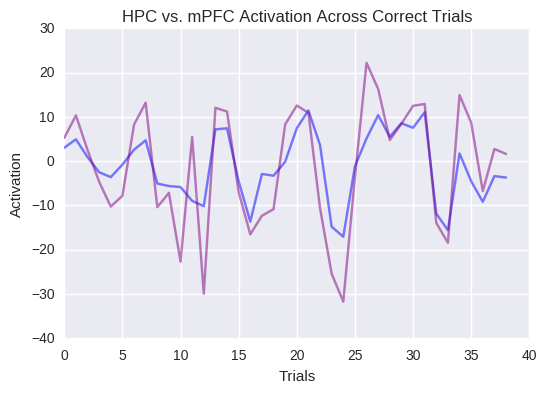

In [17]:
%matplotlib inline
# Line plot

ax = []
for a in range(0,39,1):
    ax.append(a)

x = ax

#print len(x)
y = all_data['hp_corr']
z = all_data['mPFC_corr']
#print len(y)
#print len(z)

#fit = np.polyfit(x, y, deg = 1)
#plt.plot(x, np.array(fit[0]) * np.array(x) + np.array(fit[1]), color = 'blue')
plt.plot(x, y, c = 'blue', alpha = 0.5)

#fit2 = np.polyfit(x, z, deg = 1)
#plt.plot(x, np.array(fit2[0]) * np.array(x) + np.array(fit2[1]), color = 'purple')
plt.plot(x, z, c = 'purple', alpha = 0.5)

plt.ylabel('Activation')
plt.xlabel('Trials')
plt.title('HPC vs. mPFC Activation Across Correct Trials')
plt.show()

### Hippocampus vs. mPFC: Fixed before INCORRECT

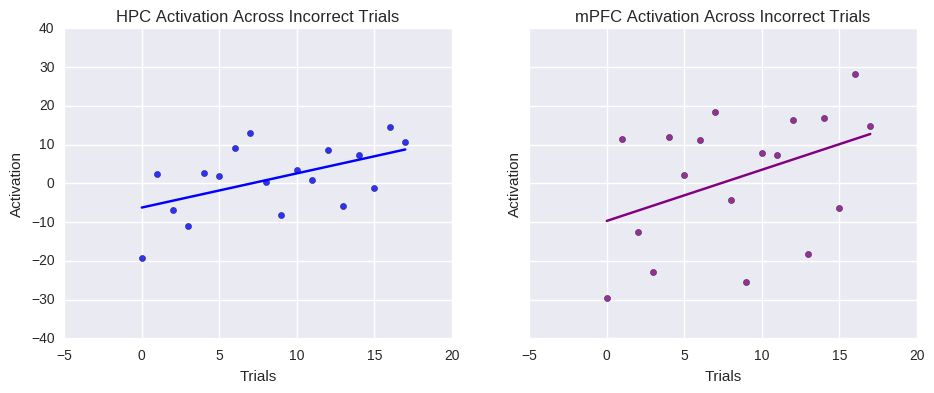

In [17]:
%matplotlib inline
# Scatterplot

ax = []
for a in range(0,18,1):
    ax.append(a)

x = ax

#print len(x)
y = all_data['hp_incorr']
z = all_data['mPFC_incorr']
#print len(y)
#print len(z)

fig, (ax, ax2) = plt.subplots(ncols = 2, figsize=(11, 4), sharex = True, sharey = True)
fit = np.polyfit(x, y, deg = 1)
ax.plot(x, np.array(fit[0]) * np.array(x) + np.array(fit[1]), color = 'blue')
ax.scatter(x, y, c = 'blue', alpha = 0.8)
ax.set_ylabel('Activation')
ax.set_xlabel('Trials')
ax.set_title('HPC Activation Across Incorrect Trials')


fit2 = np.polyfit(x, z, deg = 1)
ax2.plot(x, np.array(fit2[0]) * np.array(x) + np.array(fit2[1]), color = 'purple')
ax2.scatter(x, z, c = 'purple', alpha = 0.8)
ax2.set_ylabel('Activation')
ax2.set_xlabel('Trials')
ax2.set_title('mPFC Activation Across Incorrect Trials')

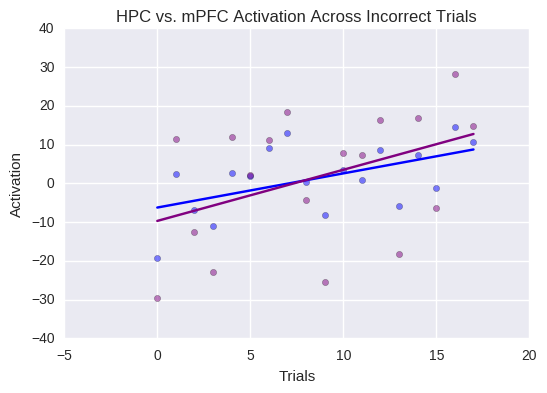

In [18]:
%matplotlib inline
# Scatterplot

ax = []
for a in range(0,18,1):
    ax.append(a)

x = ax

#print len(x)
y = all_data['hp_incorr']
z = all_data['mPFC_incorr']
#print len(y)
#print len(z)

fit = np.polyfit(x, y, deg = 1)
plt.plot(x, np.array(fit[0]) * np.array(x) + np.array(fit[1]), color = 'blue')
plt.scatter(x, y, c = 'blue', alpha = 0.5)

fit2 = np.polyfit(x, z, deg = 1)
plt.plot(x, np.array(fit2[0]) * np.array(x) + np.array(fit2[1]), color = 'purple')
plt.scatter(x, z, c = 'purple', alpha = 0.5)

plt.ylabel('Activation')
plt.xlabel('Trials')
plt.title('HPC vs. mPFC Activation Across Incorrect Trials')
plt.show()

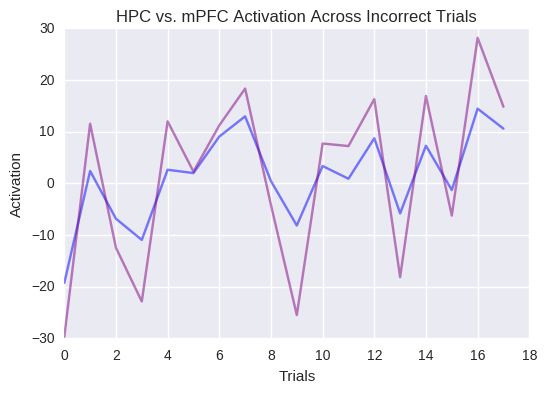

In [18]:
%matplotlib inline
# Scatterplot

ax = []
for a in range(0,18,1):
    ax.append(a)

x = ax

#print len(x)
y = all_data['hp_incorr']
z = all_data['mPFC_incorr']
#print len(y)
#print len(z)

#fit = np.polyfit(x, y, deg = 1)
#plt.plot(x, np.array(fit[0]) * np.array(x) + np.array(fit[1]), color = 'blue')
plt.plot(x, y, c = 'blue', alpha = 0.5)

#fit2 = np.polyfit(x, z, deg = 1)
#plt.plot(x, np.array(fit2[0]) * np.array(x) + np.array(fit2[1]), color = 'purple')
plt.plot(x, z, c = 'purple', alpha = 0.5)

plt.ylabel('Activation')
plt.xlabel('Trials')
plt.title('HPC vs. mPFC Activation Across Incorrect Trials')
plt.show()

### Caudate vs. dlPFC: Fixed before CORRECT

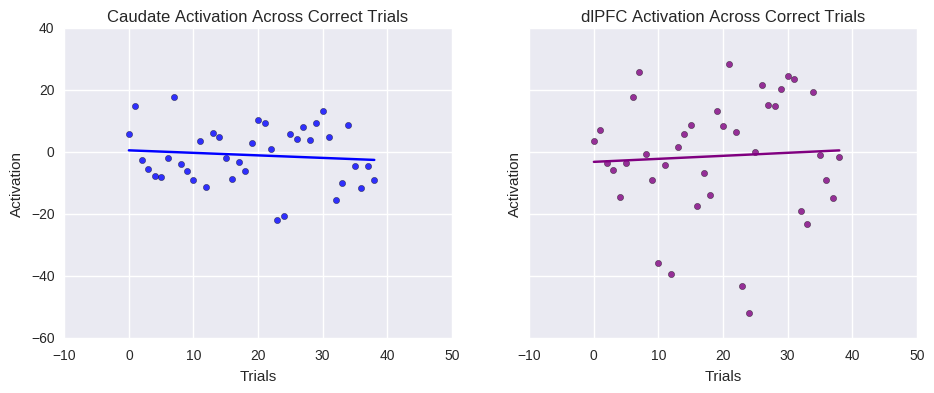

In [19]:
%matplotlib inline
# Scatterplot

ax = []
for a in range(0,39,1):
    ax.append(a)

x = ax

#print len(x)
y = all_data['caudate_corr']
z = all_data['dlPFC_corr']
#print len(y)
#print len(z)

fig, (ax, ax2) = plt.subplots(ncols = 2, figsize=(11, 4), sharex = True, sharey = True)
fit = np.polyfit(x, y, deg = 1)
ax.plot(x, np.array(fit[0]) * np.array(x) + np.array(fit[1]), color = 'blue')
ax.scatter(x, y, c = 'blue', alpha = 0.8)
ax.set_ylabel('Activation')
ax.set_xlabel('Trials')
ax.set_title('Caudate Activation Across Correct Trials')


fit2 = np.polyfit(x, z, deg = 1)
ax2.plot(x, np.array(fit2[0]) * np.array(x) + np.array(fit2[1]), color = 'purple')
ax2.scatter(x, z, c = 'purple', alpha = 0.8)
ax2.set_ylabel('Activation')
ax2.set_xlabel('Trials')
ax2.set_title('dlPFC Activation Across Correct Trials')

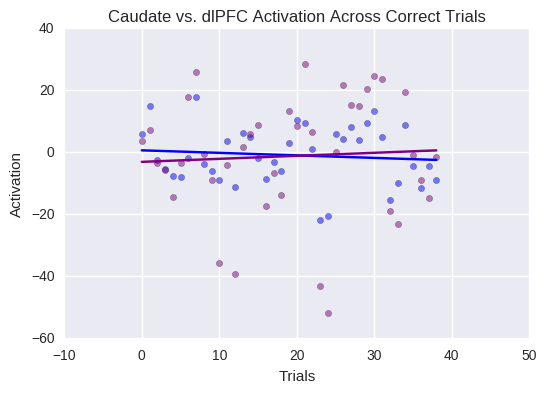

In [20]:
%matplotlib inline
# Scatterplot

ax = []
for a in range(0,39,1):
    ax.append(a)

x = ax

#print len(x)
y = all_data['caudate_corr']
z = all_data['dlPFC_corr']
#print len(y)
#print len(z)

fit = np.polyfit(x, y, deg = 1)
plt.plot(x, np.array(fit[0]) * np.array(x) + np.array(fit[1]), color = 'blue')
plt.scatter(x, y, c = 'blue', alpha = 0.5)

fit2 = np.polyfit(x, z, deg = 1)
plt.plot(x, np.array(fit2[0]) * np.array(x) + np.array(fit2[1]), color = 'purple')
plt.scatter(x, z, c = 'purple', alpha = 0.5)

plt.ylabel('Activation')
plt.xlabel('Trials')
plt.title('Caudate vs. dlPFC Activation Across Correct Trials')
plt.show()

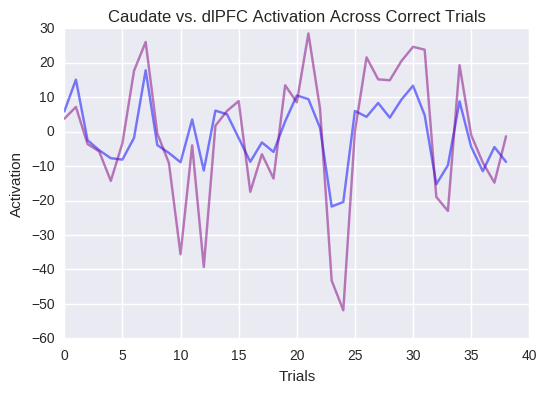

In [19]:
%matplotlib inline
# Scatterplot

ax = []
for a in range(0,39,1):
    ax.append(a)

x = ax

#print len(x)
y = all_data['caudate_corr']
z = all_data['dlPFC_corr']
#print len(y)
#print len(z)

#fit = np.polyfit(x, y, deg = 1)
#plt.plot(x, np.array(fit[0]) * np.array(x) + np.array(fit[1]), color = 'blue')
plt.plot(x, y, c = 'blue', alpha = 0.5)

#fit2 = np.polyfit(x, z, deg = 1)
#plt.plot(x, np.array(fit2[0]) * np.array(x) + np.array(fit2[1]), color = 'purple')
plt.plot(x, z, c = 'purple', alpha = 0.5)

plt.ylabel('Activation')
plt.xlabel('Trials')
plt.title('Caudate vs. dlPFC Activation Across Correct Trials')
plt.show()

### Caudate vs. dlPFC: Fixed before INCORRECT

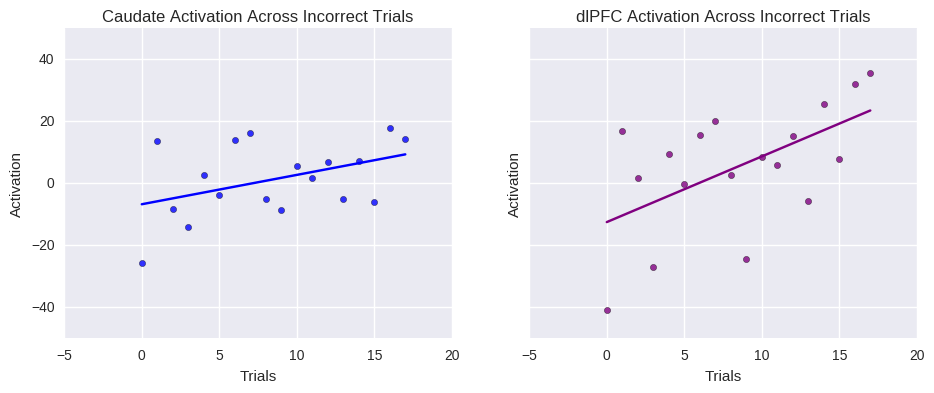

In [23]:
%matplotlib inline
# Scatterplot

ax = []
for a in range(0,18,1):
    ax.append(a)

x = ax

#print len(x)
y = all_data['caudate_incorr']
z = all_data['dlPFC_incorr']
#print len(y)
#print len(z)

fig, (ax, ax2) = plt.subplots(ncols = 2, figsize=(11, 4), sharex = True, sharey = True)
fit = np.polyfit(x, y, deg = 1)
ax.plot(x, np.array(fit[0]) * np.array(x) + np.array(fit[1]), color = 'blue')
ax.scatter(x, y, c = 'blue', alpha = 0.8)
ax.set_ylabel('Activation')
ax.set_xlabel('Trials')
ax.set_title('Caudate Activation Across Incorrect Trials')

fit2 = np.polyfit(x, z, deg = 1)
ax2.plot(x, np.array(fit2[0]) * np.array(x) + np.array(fit2[1]), color = 'purple')
ax2.scatter(x, z, c = 'purple', alpha = 0.8)
ax2.set_ylabel('Activation')
ax2.set_xlabel('Trials')
ax2.set_title('dlPFC Activation Across Incorrect Trials')

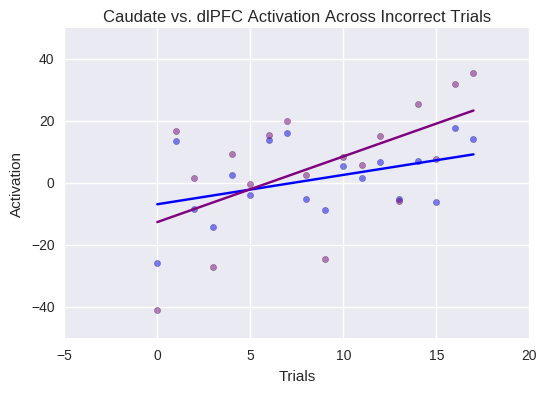

In [24]:
%matplotlib inline
# Scatterplot

ax = []
for a in range(0,18,1):
    ax.append(a)

x = ax

#print len(x)
y = all_data['caudate_incorr']
z = all_data['dlPFC_incorr']
#print len(y)
#print len(z)

fit = np.polyfit(x, y, deg = 1)
plt.plot(x, np.array(fit[0]) * np.array(x) + np.array(fit[1]), color = 'blue')
plt.scatter(x, y, c = 'blue', alpha = 0.5)

fit2 = np.polyfit(x, z, deg = 1)
plt.plot(x, np.array(fit2[0]) * np.array(x) + np.array(fit2[1]), color = 'purple')
plt.scatter(x, z, c = 'purple', alpha = 0.5)

plt.ylabel('Activation')
plt.xlabel('Trials')
plt.title('Caudate vs. dlPFC Activation Across Incorrect Trials')
plt.show()

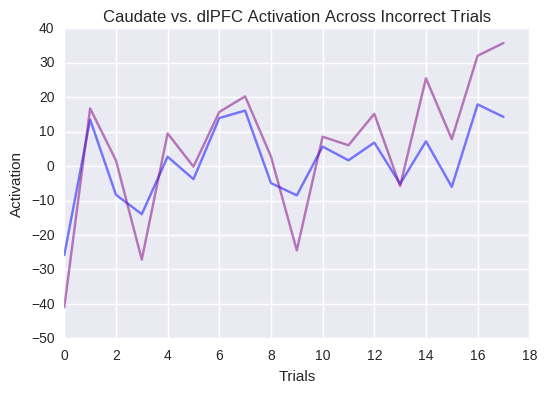

In [20]:
%matplotlib inline
# Scatterplot

ax = []
for a in range(0,18,1):
    ax.append(a)

x = ax

#print len(x)
y = all_data['caudate_incorr']
z = all_data['dlPFC_incorr']
#print len(y)
#print len(z)

#fit = np.polyfit(x, y, deg = 1)
#plt.plot(x, np.array(fit[0]) * np.array(x) + np.array(fit[1]), color = 'blue')
plt.plot(x, y, c = 'blue', alpha = 0.5)

#fit2 = np.polyfit(x, z, deg = 1)
#plt.plot(x, np.array(fit2[0]) * np.array(x) + np.array(fit2[1]), color = 'purple')
plt.plot(x, z, c = 'purple', alpha = 0.5)

plt.ylabel('Activation')
plt.xlabel('Trials')
plt.title('Caudate vs. dlPFC Activation Across Incorrect Trials')
plt.show()